# Global mean Sea Surface Temperatures

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib.dates import DateFormatter
import platform
import os

from dask.distributed import Client
from dask import delayed
import dask

plt.rcParams['figure.figsize'] = (10, 4)

#### Settings

In [97]:
year1=1982
year2=2023

In [98]:
#To compute de climatoloy
yearC1='1982'
yearC2='1992'

In [ ]:
HOME=os.environ['HOME']
USER=os.environ['USER']    

## Load data

In [119]:
if os.uname().nodename.lower().find('eemmmbp') != -1:
    base_file = HOME + '/Dropbox/Oceanografia/Data/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = './data'
elif os.uname().nodename.lower().find('rossby') != -1:
    base_file = '/data/shareddata/Satelite/noaa.oisst.v2.highres/NC/sst.day.mean'
    dataDir   = HOME + '/Analisis/SSTGlobalAnalysis/data'

In [120]:
files = [f'{base_file}.{year}.nc' for year in range(year1, year2+1)]
DS = xr.open_mfdataset(files,  chunks={'time': 365})

In [121]:
# Load data1

#titulo_short = 'NH'
#titulo = 'Northern hemisphere'
#sst = DS.sst.sel(lat=slice(0,80))

#titulo_short = 'SH'
#titulo = 'Southern hemisphere'
#sst = DS.sst.sel(lat=slice( -80, 0))

titulo_short = 'GO'
titulo = 'Global Ocean'
sst = DS.sst.sel(lat=slice( -80, 80))

#titulo_short = 'NTenerife'
#titulo = 'North Tenerife'
#sst = DS.sst.sel(lon=slice(360-16.,360-15.),lat=slice(28.50,28.75))

#titulo_short == 'ESAL'
#titulo = 'Demarcación Estrecho y Alborán'
#sst = DS.sst.sel(lat=slice(35.5,37)).sel(lon=slice(354,359))

In [122]:
sst

<xarray.DataArray 'sst' (time: 15340, lat: 640, lon: 1440)> Size: 57GB
dask.array<getitem, shape=(15340, 640, 1440), dtype=float32, chunksize=(365, 640, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 123kB 1982-01-01 1982-01-02 ... 2023-12-31
  * lat      (lat) float32 3kB -79.88 -79.62 -79.38 -79.12 ... 79.38 79.62 79.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.48]

## Global mean

>>>>> Global OceanGO
    > Global mean


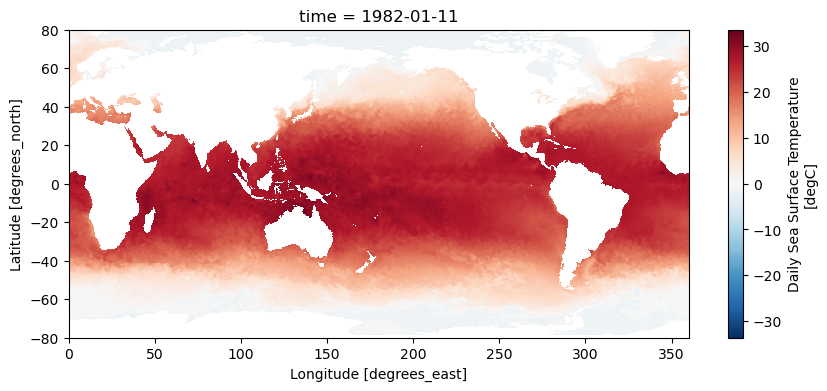

In [123]:
sst[10,:,:].plot()
print('>>>>> '+titulo+titulo_short)
print('    > Global mean')

In [124]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_weighted = sst.weighted(weights)
sst_wmean = sst_weighted.mean(("lon", "lat"),skipna=True).load()

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [125]:
#Create monthly climatology
sst_clim = sst.sel(time=slice(yearC1,yearC2)).groupby('time.dayofyear').mean(dim='time').load();

In [126]:
#Create anomaly
sst_anom = sst.groupby('time.dayofyear') - sst_clim

/Users/pvb/miniconda3/envs/ocean/lib/python3.11/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]


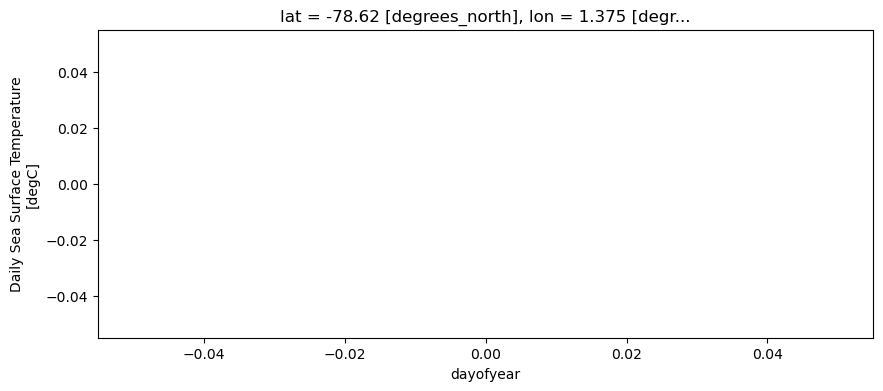

In [127]:
sst_clim[:,5,5].plot()

## Global mean anomaly

In [128]:
# Calculate global mean weigthtened
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area.
weights = np.cos(np.deg2rad(sst.lat))
weights = weights/weights.max()
weights.name = "weights"
sst_anom_weighted = sst_anom.weighted(weights)
sst_anom_wmean = sst_anom_weighted.mean(("lon", "lat"),skipna=True).load()

In [129]:
# smoothed versions
sst_wmean_rolling = sst_wmean.rolling(time=360,center=True).mean()
sst_anom_wmean_rolling = sst_anom_wmean.rolling(time=360,center=True).mean()

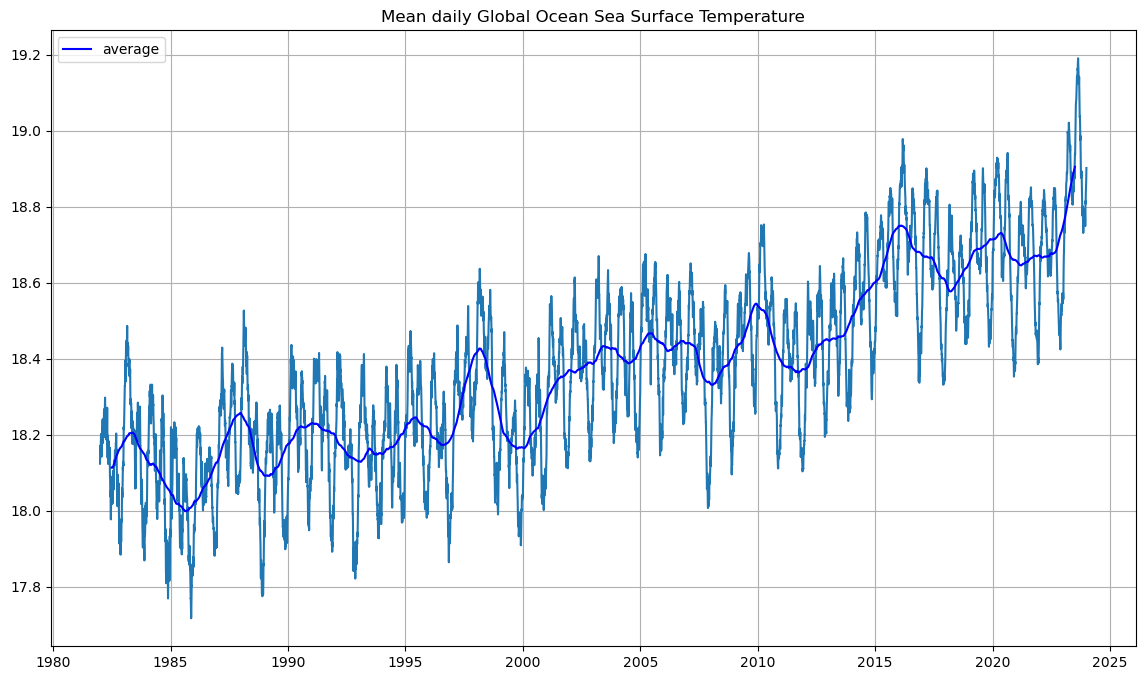

In [130]:
fig, ax = plt.subplots(1, 1 , figsize=(14,8))
ax.plot(sst_wmean.time,sst_wmean)
ax.plot(sst_wmean_rolling.time,sst_wmean_rolling,'-b',label='average')
ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature');

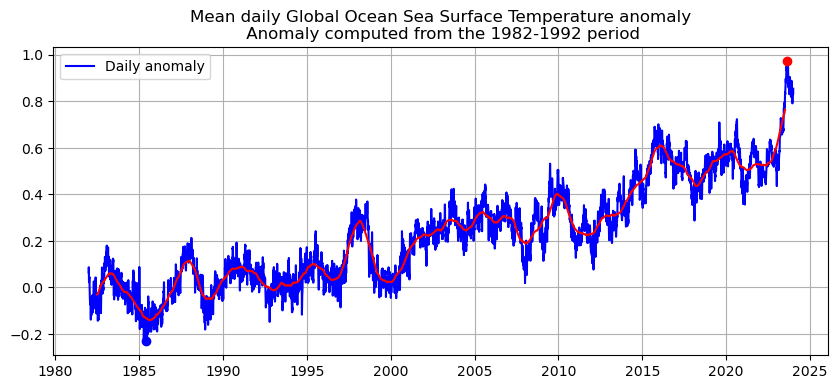

In [131]:
fig, ax = plt.subplots(1, 1 , figsize=(10,4))
ax.plot(sst_anom_wmean.time        ,sst_anom_wmean,'b',label='Daily anomaly')
ax.plot(sst_anom_wmean_rolling.time,sst_anom_wmean_rolling,'r')

ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmax(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmax(...)),'ro')
ax.plot(sst_anom_wmean.time.isel(sst_anom_wmean.argmin(...)),
        sst_anom_wmean.isel(sst_anom_wmean.argmin(...)),'bo')

ax.grid()
ax.legend()
ax.set_title('Mean daily '+titulo+' Sea Surface Temperature anomaly\n Anomaly computed from the 1982-1992 period');

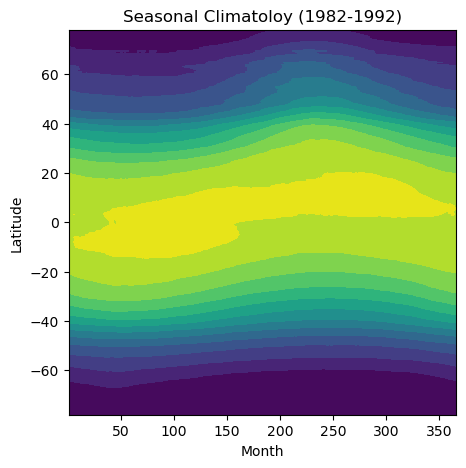

In [132]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(sst_clim.mean(dim='lon').dayofyear,
                 sst_clim.mean(dim='lon').lat,
                 sst_clim.mean(dim='lon').transpose(),levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

In [133]:
sst_anom_LD=sst_anom[-1,:,:]
sst_anom_LD

<xarray.DataArray 'sst' (lat: 640, lon: 1440)> Size: 4MB
dask.array<getitem, shape=(640, 1440), dtype=float32, chunksize=(640, 1440), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 8B 2023-12-31
  * lat        (lat) float32 3kB -79.88 -79.62 -79.38 ... 79.38 79.62 79.88
  * lon        (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
    dayofyear  int64 8B 365

In [134]:
sst_anom_LD.to_netcdf(dataDir + '/PsstLD_anom_'+titulo_short+'.nc',mode='w')
sst_wmean.to_netcdf(dataDir + '/Psstd_mean_'+titulo_short+'.nc',mode='w')
sst_clim.to_netcdf(dataDir + '/Psstd_clim_'+titulo_short+'.nc',mode='w')
sst_anom_wmean.to_netcdf(dataDir + '/Psstd_anom_mean_'+titulo_short+'.nc',mode='w')